### Day 16 - Proboscidea Volcanium

##### Part 1 - Release Valves

What is the most pressure that you can release in 30 minutes?

In [809]:
from collections import defaultdict

def get_data(input_file):
    with open(input_file, "r") as f:
        data = [ [a.strip(',') for a in line.split(" ")[1:] if a not in ['has', 'flow', 'tunnel', 'tunnels', 'lead','leads', 'to', 'valve', 'valves']] \
            for line in f.read().strip().split("\n")]
           
    D = {d[0] : (int(data[i][1][:-1].split("=")[1]), data[i][2:]) for i,d in enumerate(data)}

    flows = {d : D[d][0] for d in D.keys()}
    neighbors = {d : D[d][1] for d in D.keys()}
    valve_binary_map = {valve : 1 << i for i,valve in enumerate(D.keys())}
    candle = 1 << (len(D))
    
    for valve in filter(lambda x : D[x][0] == 0, D.keys()):
        candle |= valve_binary_map[valve]
        
    return flows, neighbors, valve_binary_map, candle

In [810]:
cache = defaultdict()
input_file = "aoc_16_input.txt"
p1_flows, p1_neighbors, valve_binary_map, candle = get_data(input_file)

def dfs(node, timeRemaining, openedValves, currFlowRate):
    if timeRemaining == 0:                          
        return 0

    k = hash((timeRemaining, openedValves, node)) 
    if k in cache:                                  
        return cache[k]

    best = 0       
        # not already open, costs 1 min to open
    if not (openedValves & valve_binary_map[node]):
        best = max(best, dfs(node, timeRemaining - 1, openedValves | valve_binary_map[node], currFlowRate + p1_flows[node])  ) 

        # try neighbors, without opening
    for neighbor in p1_neighbors[node]:
        best = max(best,  dfs(neighbor, timeRemaining - 1, openedValves, currFlowRate)  )

    res = best + currFlowRate
    cache[hash((timeRemaining, openedValves, node))] = res

    return res

print(f"Part 1: Most pressure released = {dfs('AA', 30, candle, 0)}")

Most pressure released = 1737


### Part 2

Spend 4 minutes training an elephant to help you open valves. Now what is the best the two of you can do in 26 minutes?

In [811]:
import networkx as nx
import matplotlib.pyplot as plt

def yield_digraph(data):
    D = nx.Graph()
    D.add_nodes_from(data.keys() )
    D.add_weighted_edges_from([(valve, endpoint, 1) for valve in data for endpoint in data[valve] ])
        
    color_map = []
    for node, fr in D.nodes(data = "Flow rate"):
        if node =='AA':
            color_map.append("tab:green")
            continue
        elif fr == 0:
            color_map.append("white")
        else:
            color_map.append("tab:blue")
    
    plt.figure(1, figsize=(12,12))
    options = {"edgecolors": "tab:gray", "node_size": 600, "alpha": 0.9}
    graph_pos = nx.spring_layout(D, k = 0.05, iterations=250, weight="weight")
    nx.draw_networkx_nodes(D, graph_pos, node_color=color_map, **options)
    nx.draw_networkx_labels(D, graph_pos, font_size=10)
    nx.draw_networkx_edges(D, graph_pos, edgelist=D.edges(), arrows=True, alpha=0.5)
    #labels = nx.get_edge_attributes(D, "weight")
    #nx.draw_networkx_edge_labels(D, graph_pos, edge_labels=labels)
    plt.show()
    return D

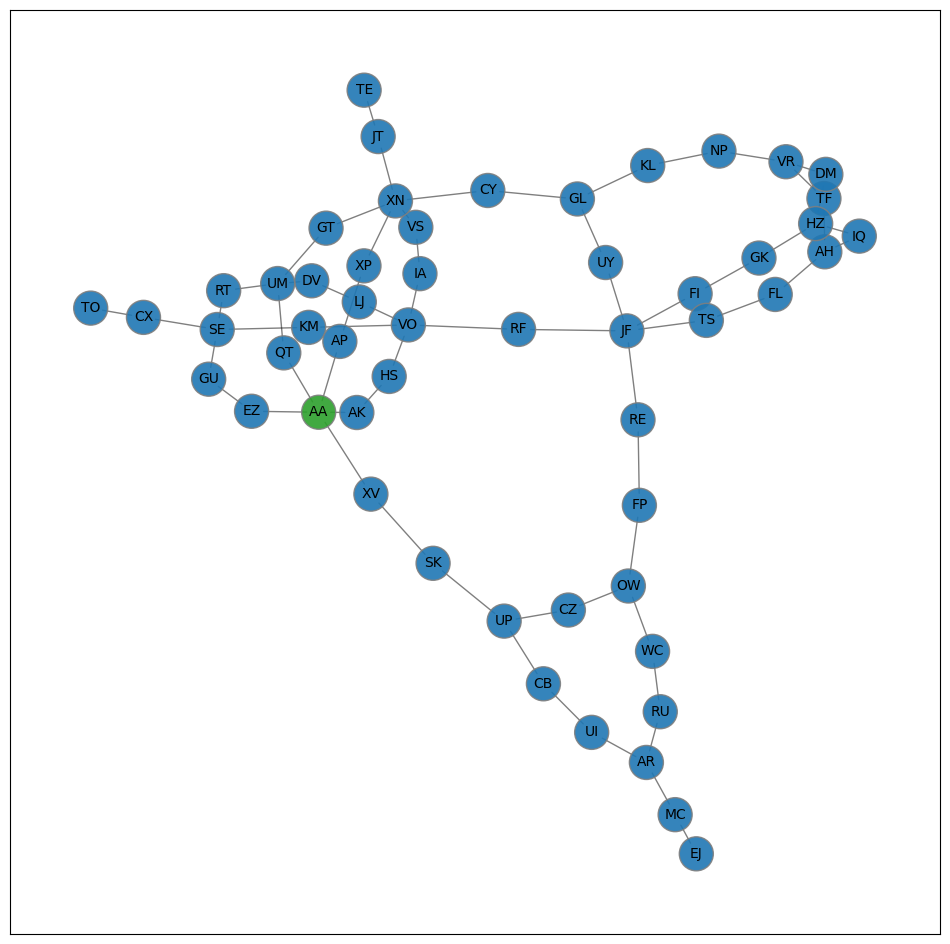

In [812]:
DG = yield_digraph(p1_neighbors)
# for now just displaying a graph for analysis
# will come back to part 2 later